# CWA Determination: XGB Ensembles


# Authenticate to Colab

In [1]:
# AUTHENTICATE to Google Colab using your Colab credentials
from google.colab import auth
auth.authenticate_user()

# Mount GDrive

In [2]:
# IMPORT & MOUNT gDrive so we can access files from here
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Python Packages

In [134]:
# install xgboost
!pip install xgboost

# install iterative stratification
!pip install iterative-stratification


In [135]:
import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import isnan

# import pickle5 as pickle
import os
import random

import matplotlib.pyplot as plt

from collections import Counter

import time

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

import seaborn as sns

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import Pipeline

# from mlxtend.evaluate import bias_variance_decomp

from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression

# Set the randomizer seed so results are the same each time.
np.random.seed(123)

pd.set_option('display.float_format', '{:.2f}'.format)

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# PREPARE DATA SETS

## Load Data

In [136]:
# Load Data

full_df = pd.read_csv(r"/content/drive/MyDrive/Colab/Data/2021.03.17_full_dataset.csv")


In [137]:
for c in full_df.columns:
  print(c)

Unnamed: 0
cwa4
cwa8
cwa7
cwa_determination
cwa5
longitude
cwa3
date_issued_or_denied
latitude
Index
cwa1
da_number
jurisdiction_type
rha_determination
cwa9
cwa2
rha2
potential_wetland
district
cwa6
rha1
hydclprs
mukey
drclassdcd
wtdepaprju
slopegradd
aws025wta
flodfreqdc
wtdepannmi
pondfreqpr
slope_stdev_200m
transition_8_200m
seasonality_mean_200m
transition_0_200m
recurrence_min_200m
elevation_min_200m
seasonality_min_200m
transition_2_200m
slope_min_200m
transition_3_200m
seasonality_stdev_200m
slope_mean_200m
recurrence_mean_200m
transition_5_200m
transition_7_200m
elevation_mean_200m
slope_max_200m
elevation_max_200m
seasonality_max_200m
transition_6_200m
transition_4_200m
elevation_stdev_200m
transition_1_200m
recurrence_max_200m
recurrence_stdev_200m
transition_9_200m
fl_totdasqkm_sum_200m
fl_gnis_name_ind_mean_200m
fl_ftype_streamriver_200m
fl_ftype_connector_200m
fl_intephem_count_200m
fl_startflag_mean_200m
fl_divergence_sum_200m
fl_ftype_coastline_200m
fl_startflag_sum_200m

## Extract model data

In [138]:
# Extract relevant columns
model_data = full_df[[

                'cwa_determination',
                'da_number',
                'district',
                'latitude', 'longitude',
               'hydclprs', 
               'aws025wta',
               'slopegradd',
               'wtdepannmi',
               'flodfreqdc',
               'pondfreqpr',
               'wtdepaprju',
                
               'fl_areasqkm_sum_200m',
               'fl_gnis_name_ind_count_200m',
               'fl_totdasqkm_sum_200m',
               'fl_streamorde_sum_200m',
               'fl_startflag_sum_200m',
               'fl_divergence_mean_200m',
                
               'wb_area_sum_200m',
               'wb_gnis_name_ind_count_200m',
                
               'fl_areasqkm_sum_2500m',
              #  'fl_gnis_name_ind_count_2500m',
              #  'fl_totdasqkm_sum_2500m',
              #  'fl_flow_type_sum_2500m',
              #  'fl_streamorde_sum_2500m',
              #  'fl_intephem_mean_2500m',
              #  'fl_startflag_sum_2500m',
              #  'fl_divergence_mean_2500m',
                
              #  'wb_area_sum_2500m',
              #  'wb_gnis_name_ind_count_2500m',
                
              #   'elevation_mean_200m',
              #   'elevation_mean_2500m',
              #   'elevation_stdev_200m',
              #   'elevation_stdev_2500m',

                'fl_ftype_artificialpath_200m',
                # 'fl_ftype_artificialpath_2500m',
                'fl_ftype_canalditch_200m',
                # 'fl_ftype_canalditch_2500m',
                'fl_ftype_coastline_200m',
                # 'fl_ftype_coastline_2500m',
                # 'fl_ftype_connector_2500m',
                # 'fl_ftype_pipeline_2500m',
                'fl_ftype_streamriver_200m',
                # 'fl_ftype_streamriver_2500m',

                'wb_ftype_canalditch_200m',
                # 'wb_ftype_canalditch_2500m',
                # 'wb_ftype_connector_2500m',
                'wb_ftype_pipeline_200m',
                # 'wb_ftype_streamriver_2500m',

                # 'nwi_WATER_REGIME_NAME_artificially_flooded_2500m',
                # 'nwi_WATER_REGIME_NAME_continuously__saturated_2500m',
                'nwi_WATER_REGIME_NAME_intermittently_exposed_200m',
                # 'nwi_WATER_REGIME_NAME_intermittently_exposed_2500m',
                # 'nwi_WATER_REGIME_NAME_intermittently_flooded_2500m',
                # 'nwi_WATER_REGIME_NAME_irregularly_exposed_2500m',
                'nwi_WATER_REGIME_NAME_irregularly_flooded_200m',
                # 'nwi_WATER_REGIME_NAME_irregularly_flooded_2500m',
                'nwi_WATER_REGIME_NAME_permanently_flooded-tidal_200m',
                # 'nwi_WATER_REGIME_NAME_permanently_flooded-tidal_2500m',
                'nwi_WATER_REGIME_NAME_permanently_flooded_200m',
                # 'nwi_WATER_REGIME_NAME_permanently_flooded_2500m',
                'nwi_WATER_REGIME_NAME_regularly_flooded_200m',
                # 'nwi_WATER_REGIME_NAME_regularly_flooded_2500m',
                # 'nwi_WATER_REGIME_NAME_seasonally_flooded-tidal_2500m',
                # 'nwi_WATER_REGIME_NAME_seasonally_flooded/saturated_2500m',
                'nwi_WATER_REGIME_NAME_seasonally_flooded_200m',
                # 'nwi_WATER_REGIME_NAME_seasonally_flooded_2500m',
                'nwi_WATER_REGIME_NAME_seasonally_saturated_200m',
                # 'nwi_WATER_REGIME_NAME_seasonally_saturated_2500m',
                # 'nwi_WATER_REGIME_NAME_semipermanently_flooded-tidal_2500m',
                'nwi_WATER_REGIME_NAME_semipermanently_flooded_200m',
                # 'nwi_WATER_REGIME_NAME_semipermanently_flooded_2500m',
                'nwi_WATER_REGIME_NAME_subtidal_200m',
                # 'nwi_WATER_REGIME_NAME_subtidal_2500m',
                # 'nwi_WATER_REGIME_NAME_temporary_flooded-tidal_2500m',
                'nwi_WATER_REGIME_NAME_temporary_flooded_200m',
                # 'nwi_WATER_REGIME_NAME_temporary_flooded_2500m',
                'nwi_WATER_REGIME_NAME_zzz_200m',
                # 'nwi_WATER_REGIME_NAME_zzz_2500m',

                'nwi_CLASS_NAME_aquatic_bed_200m',
                # 'nwi_CLASS_NAME_aquatic_bed_2500m',
                'nwi_CLASS_NAME_emergent_200m',
                # 'nwi_CLASS_NAME_emergent_2500m',
                'nwi_CLASS_NAME_forested_200m',
                # 'nwi_CLASS_NAME_forested_2500m',
                # 'nwi_CLASS_NAME_reef_2500m',
                # 'nwi_CLASS_NAME_rocky_shore_2500m',
                # 'nwi_CLASS_NAME_scrub-shrub_200m',
                # 'nwi_CLASS_NAME_scrub-shrub_2500m',
                'nwi_CLASS_NAME_streambed_200m',
                # 'nwi_CLASS_NAME_streambed_2500m',
                'nwi_CLASS_NAME_unconsolidated_bottom_200m',
                # 'nwi_CLASS_NAME_unconsolidated_bottom_2500m',
                'nwi_CLASS_NAME_unconsolidated_shore_200m',
                # 'nwi_CLASS_NAME_unconsolidated_shore_2500m',
                # 'nwi_CLASS_NAME_zzz_2500m',

'slope_stdev_200m',
'transition_8_200m',
'seasonality_mean_200m',
'transition_0_200m',
'recurrence_min_200m',
'elevation_min_200m',
'seasonality_min_200m',
'transition_2_200m',
'slope_min_200m',
'transition_3_200m',
'seasonality_stdev_200m',
'slope_mean_200m',
'recurrence_mean_200m',
'transition_5_200m',
'transition_7_200m',
'elevation_mean_200m',
'slope_max_200m',
'elevation_max_200m',
'seasonality_max_200m',
'transition_6_200m',
'transition_4_200m',
'elevation_stdev_200m',
'transition_1_200m',
'recurrence_max_200m',
'recurrence_stdev_200m',
'transition_9_200m'
]].copy()

# Lat/Lon Feature Engineering
model_data['x_coord'] = np.cos(model_data['latitude']) * np.cos(model_data['longitude'])
model_data['y_coord'] = np.cos(model_data['latitude']) * np.sin(model_data['longitude'])
model_data['z_coord'] = np.sin(model_data['latitude'])

model_data.shape

(14619, 73)

In [139]:
# # Extract relevant columns
# model_data = full_df[[
#                 'date_issued_or_denied',
#                 'cwa_determination',
#                 'da_number',
#                 'district',
#                 'latitude', 'longitude',

#                'hydclprs', 
#                'aws025wta',
#                'slopegradd',
#                'wtdepannmi',
#                'flodfreqdc',
#                'pondfreqpr',
#                'wtdepaprju',
                
#                'fl_areasqkm_sum_200m',
#                'fl_gnis_name_ind_count_200m',
#                'fl_totdasqkm_sum_200m',
#                'fl_streamorde_sum_200m',
#                'fl_startflag_sum_200m',
#                'fl_divergence_mean_200m',
                
#                'wb_area_sum_200m',
#                'wb_gnis_name_ind_count_200m',
                
#                'fl_areasqkm_sum_2500m',
#                'fl_gnis_name_ind_count_2500m',
#                'fl_totdasqkm_sum_2500m',
#                'fl_flow_type_sum_2500m',
#                'fl_streamorde_sum_2500m',
#                'fl_intephem_mean_2500m',
#                'fl_startflag_sum_2500m',
#                'fl_divergence_mean_2500m',
                
#                'wb_area_sum_2500m',
#                'wb_gnis_name_ind_count_2500m',
                
#                 'elevation_mean_200m',
#                 'elevation_stdev_200m',
                
#                 'elevation_stdev_2500m',
#                 'elevation_mean_2500m',

#                 'fl_ftype_artificialpath_200m',
#                 'fl_ftype_canalditch_200m',
#                 'fl_ftype_coastline_200m',
#                 'fl_ftype_streamriver_200m',
                
#                 'fl_ftype_artificialpath_2500m',
#                 'fl_ftype_canalditch_2500m',
#                 'fl_ftype_coastline_2500m',
#                 'fl_ftype_connector_2500m',
#                 'fl_ftype_pipeline_2500m',
#                 'fl_ftype_streamriver_2500m',

#                 'wb_ftype_canalditch_200m',
#                 'wb_ftype_pipeline_200m',

#                 'wb_ftype_canalditch_2500m',
#                 'wb_ftype_connector_2500m',
#                 'wb_ftype_streamriver_2500m',

#                  'nwi_WATER_REGIME_NAME_intermittently_exposed_200m',
#                  'nwi_WATER_REGIME_NAME_irregularly_flooded_200m',
#                  'nwi_WATER_REGIME_NAME_permanently_flooded-tidal_200m',
#                  'nwi_WATER_REGIME_NAME_permanently_flooded_200m',
#                  'nwi_WATER_REGIME_NAME_regularly_flooded_200m',
#                  'nwi_WATER_REGIME_NAME_seasonally_flooded_200m',
#                  'nwi_WATER_REGIME_NAME_semipermanently_flooded_200m',
#                  'nwi_WATER_REGIME_NAME_subtidal_200m',
#                  'nwi_WATER_REGIME_NAME_temporary_flooded_200m',
#                  'nwi_WATER_REGIME_NAME_seasonally_saturated_200m',
#                  'nwi_WATER_REGIME_NAME_zzz_200m',
#                  'nwi_CLASS_NAME_aquatic_bed_200m',
#                  'nwi_CLASS_NAME_emergent_200m',
#                  'nwi_CLASS_NAME_forested_200m',
#                  'nwi_CLASS_NAME_scrub-shrub_200m',
#                  'nwi_CLASS_NAME_streambed_200m',
#                  'nwi_CLASS_NAME_unconsolidated_bottom_200m',
#                  'nwi_CLASS_NAME_unconsolidated_shore_200m',
                 
#                 'nwi_WATER_REGIME_NAME_artificially_flooded_2500m',
#                 'nwi_WATER_REGIME_NAME_continuously__saturated_2500m',
#                 'nwi_WATER_REGIME_NAME_intermittently_exposed_2500m',
#                 'nwi_WATER_REGIME_NAME_intermittently_flooded_2500m',
#                 'nwi_WATER_REGIME_NAME_irregularly_exposed_2500m',
#                 'nwi_WATER_REGIME_NAME_irregularly_flooded_2500m',
#                 'nwi_WATER_REGIME_NAME_permanently_flooded-tidal_2500m',
#                 'nwi_WATER_REGIME_NAME_permanently_flooded_2500m',
#                 'nwi_WATER_REGIME_NAME_regularly_flooded_2500m',
#                 'nwi_WATER_REGIME_NAME_seasonally_flooded-tidal_2500m',
#                 'nwi_WATER_REGIME_NAME_seasonally_flooded/saturated_2500m',
#                 'nwi_WATER_REGIME_NAME_seasonally_flooded_2500m',
#                 'nwi_WATER_REGIME_NAME_seasonally_saturated_2500m',
#                 'nwi_WATER_REGIME_NAME_semipermanently_flooded-tidal_2500m',
#                 'nwi_WATER_REGIME_NAME_semipermanently_flooded_2500m',
#                 'nwi_WATER_REGIME_NAME_subtidal_2500m',
#                 'nwi_WATER_REGIME_NAME_temporary_flooded-tidal_2500m',
#                 'nwi_WATER_REGIME_NAME_temporary_flooded_2500m',
#                 'nwi_WATER_REGIME_NAME_zzz_2500m',
#                 'nwi_CLASS_NAME_aquatic_bed_2500m',
#                 'nwi_CLASS_NAME_emergent_2500m',
#                 'nwi_CLASS_NAME_forested_2500m',
#                 'nwi_CLASS_NAME_reef_2500m',
#                 'nwi_CLASS_NAME_rocky_shore_2500m',
#                 'nwi_CLASS_NAME_scrub-shrub_2500m',
#                 'nwi_CLASS_NAME_streambed_2500m',
#                 'nwi_CLASS_NAME_unconsolidated_bottom_2500m',
#                 'nwi_CLASS_NAME_unconsolidated_shore_2500m',
#                 'nwi_CLASS_NAME_zzz_2500m'
#                ]].copy()

# # Lat/Lon Feature Engineering
# model_data['x_coord'] = np.cos(model_data['latitude']) * np.cos(model_data['longitude'])
# model_data['y_coord'] = np.cos(model_data['latitude']) * np.sin(model_data['longitude'])
# model_data['z_coord'] = np.sin(model_data['latitude'])

# model_data.shape

## One hot encode categorical features

In [140]:
# One Hot Encode categorical variables
cat_cols = ['flodfreqdc']
for c in cat_cols:
  enc_df = pd.get_dummies(model_data[c], prefix='')
  model_data = model_data.join(enc_df)
  model_data.drop(c, axis=1, inplace=True)

model_data.shape

(14619, 78)

## Prepare X, Y

In [141]:
drop_cols = ['da_number', 'district', 'latitude', 'longitude', 'cwa_determination']

# for model data
Y = model_data[["cwa_determination"]]
X = model_data.copy()
X.drop(columns=drop_cols, inplace = True)

print(X.shape)
print(Y.shape)


(14619, 73)
(14619, 1)


## Prepare Train, Test, Validate datasets
Train 1: 35%  
Train 2: 35%  
Test1: 15%  
Test2: 15%


### Train_Test_Split()

In [142]:
# # Split data into train and test sets
# X_train_set, X_test_set, Y_train_set, Y_test_set = train_test_split(X, Y, test_size=0.30, random_state=1, stratify=Y, shuffle=True)

# # Split train data into train1 and train2
# X_train1, X_train2, Y_train1, Y_train2 = train_test_split(X_train_set, Y_train_set, test_size=0.50, random_state=1, stratify=Y_train_set, shuffle=True)

# # Split test data into test1 and test2
# X_test1, X_test2, Y_test1, Y_test2 = train_test_split(X_test_set, Y_test_set, test_size=0.50, random_state=1, stratify=Y_test_set, shuffle=True)

# print(X_train_set.shape,Y_train_set.shape)
# print(X_test_set.shape, Y_test_set.shape)
# print(X_train1.shape, Y_train1.shape)
# print(X_train2.shape, Y_train2.shape)
# print(X_test1.shape, Y_test1.shape)
# print(X_test2.shape, Y_test2.shape)

### StratifiedShuffleSplit()

In [143]:
# Split into train1, train2, test1, test2

# Split data into train and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, Y):
  X_train_set, X_test_set = X.iloc[train_index], X.iloc[test_index]
  Y_train_set, Y_test_set = Y.iloc[train_index], Y.iloc[test_index]

# Split train data into train1 and train2
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index1, train_index2 in sss_train.split(X_train_set, Y_train_set):
  X_train1, X_train2 = X_train_set.iloc[train_index1], X_train_set.iloc[train_index2]
  Y_train1, Y_train2 = Y_train_set.iloc[train_index1], Y_train_set.iloc[train_index2]

# Split test data into test1 and test2
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for test_index1, test_index2 in sss_test.split(X_test_set, Y_test_set):
  X_test1, X_test2 = X_test_set.iloc[test_index1], X_test_set.iloc[test_index2]
  Y_test1, Y_test2 = Y_test_set.iloc[test_index1], Y_test_set.iloc[test_index2]


print(X_train_set.shape,Y_train_set.shape)
print(X_test_set.shape, Y_test_set.shape)
print(X_train1.shape, Y_train1.shape)
print(X_train2.shape, Y_train2.shape)
print(X_test1.shape, Y_test1.shape)
print(X_test2.shape, Y_test2.shape)

(10233, 73) (10233, 1)
(4386, 73) (4386, 1)
(5116, 73) (5116, 1)
(5117, 73) (5117, 1)
(2193, 73) (2193, 1)
(2193, 73) (2193, 1)


### Test for overlap of data between sets

In [144]:
# Ensuring that there is no data overlap between the different sets of data 
# if output is null then it means there is no overlap of data points and that the datasets are mutually exclusive

# create list of index values from train1 and train2
train1_list = X_train1.index.to_list()
train2_list = X_train2.index.to_list()

train1_list_as_set = set(train1_list)
intersection = train1_list_as_set.intersection(train2_list)
intersection_as_list = list(intersection)
print(intersection_as_list)

# create list of index values from test1 and test2
test1_list = X_test1.index.to_list()
test2_list = X_test2.index.to_list()

test2_list_as_set = set(test2_list)
intersection = test2_list_as_set.intersection(test1_list)
intersection_as_list = list(intersection)
print(intersection_as_list)

[]
[]


### Ensure indices are carried over

In [145]:
print("\nAfter split 1:")
print(X_train_set.index)
print(Y_train_set.index)
print(X_test_set.index)
print(Y_test_set.index)

print("\nAfter split 2:")
print(X_train1.index)
print(Y_train1.index)
print(X_train2.index)
print(Y_train2.index)

print("\nAfter split 3:")
print(X_test1.index)
print(Y_test1.index)
print(X_test2.index)
print(Y_test2.index)



After split 1:
Int64Index([14238, 13545,  1434,  6533, 13211,  5105,  3621, 13885,  8793,
             1037,
            ...
            12736, 13380,  5397,  4913,  9060, 13315,  6606,  3837,  4147,
            11424],
           dtype='int64', length=10233)
Int64Index([14238, 13545,  1434,  6533, 13211,  5105,  3621, 13885,  8793,
             1037,
            ...
            12736, 13380,  5397,  4913,  9060, 13315,  6606,  3837,  4147,
            11424],
           dtype='int64', length=10233)
Int64Index([12607, 11917,  6649,  7340, 10306, 11745,  3584, 14222,  7885,
             4510,
            ...
             1566,  6665,  1393,  4103,  1965,  4907, 10009, 13868, 13797,
             8478],
           dtype='int64', length=4386)
Int64Index([12607, 11917,  6649,  7340, 10306, 11745,  3584, 14222,  7885,
             4510,
            ...
             1566,  6665,  1393,  4103,  1965,  4907, 10009, 13868, 13797,
             8478],
           dtype='int64', length=4386)

After

# STAGE 1: Prepare train data for Logistic Regression using XGB models

## Train Model 1 on "train1" dataset

In [146]:
# MODEL 1 - XGB

# Impute 
imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer1 = imputer1.fit(X_train1)
X_train1_imp = imputer1.transform(X_train1)

# Assign y
y_train1 = np.ravel(Y_train1)

# Instantiate model

model1 = XGBClassifier(objective='binary:logistic',
                       booster='gbtree',
                       learning_rate=0.2,
                       n_estimators=1000,
                       max_depth=6,
                       min_child_weight=2,
                       gamma=0.3,
                       subsample=0.9,
                       colsample_bytree=0.7,
                       reg_lambda=0,
                       reg_alpha=0,
                       max_delta_step=1,
                       seed=27,
                       eval_metric='error'
                       )  

# Train model
model1.fit(X_train1_imp, y_train1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='error',
              gamma=0.3, learning_rate=0.2, max_delta_step=1, max_depth=6,
              min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.9, verbosity=1)

## Train Model 2 on "train2" dataset

In [147]:
# MODEL 2 - XGB

# Create imputer to replace missing values 
imputer2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer2 = imputer2.fit(X_train2)
X_train2_imp = imputer2.transform(X_train2)

# Assign y
y_train2 = np.ravel(Y_train2)

model2 = XGBClassifier(objective='binary:logistic',
                       booster='gbtree',
                       learning_rate=0.2,
                       n_estimators=1000,
                       max_depth=8,
                       min_child_weight=2,
                       gamma=0.4,
                       subsample=0.9,
                       colsample_bytree=0.9,
                       reg_lambda=0,
                       reg_alpha=0,
                       max_delta_step=1,
                       seed=27,
                       eval_metric='error'
                       )  

# Train model
model2.fit(X_train2_imp, y_train2)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='error',
              gamma=0.4, learning_rate=0.2, max_delta_step=1, max_depth=8,
              min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.9, verbosity=1)

## Predict test1 with Model 1

XGBoost Model 1


Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1382
           1       0.66      0.53      0.59       811

    accuracy                           0.72      2193
   macro avg       0.70      0.68      0.69      2193
weighted avg       0.72      0.72      0.72      2193

Balanced Accuracy Score: 68.41%
ROC_AUC: 0.684 




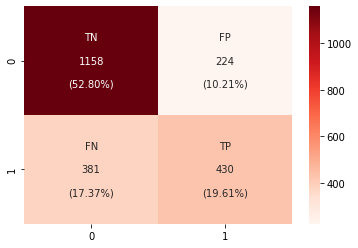

In [148]:
# Predict with Model 1

# Assign and Impute X
X_test_imp = imputer1.transform(X_test1)

# Assign y
y_test = np.ravel(Y_test1)

# Predict 
y_pred1 = model1.predict(X_test_imp)
y_pred_proba1 = model1.predict_proba(X_test_imp)

print("XGBoost Model 1\n")

# print classification report
print("\nClassification Report:\n",)
print(metrics.classification_report(y_test, y_pred1, digits=2))

# print balanced_accuracy score
print("Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_test, y_pred1)*100))

# calculate ROC_AUC score
auc = roc_auc_score(y_test, y_pred1)
print('ROC_AUC: %.3f' % auc, "\n\n")

# generate pretty Confusion Matrix
result = confusion_matrix(y_test, y_pred1)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')

In [149]:
# # generate cross validation scores
# score = cross_val_score(model1, X_test_imp, y_test, cv=10, scoring='roc_auc')
# print("%0.2f ROC_AUC with a standard deviation of %0.2f" % (score.mean(), score.std()))

# score = cross_val_score(model1, X_test_imp, y_test, cv=10, scoring='balanced_accuracy')
# print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (score.mean(), score.std()))

# ppv = cross_val_score(model1, X_test_imp, y_test, cv=10, scoring='precision')
# print("%0.2f PPV with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))


## Predict test1 with Model 2

XGBoost Model


Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.85      0.80      1382
           1       0.68      0.57      0.62       811

    accuracy                           0.74      2193
   macro avg       0.73      0.71      0.71      2193
weighted avg       0.74      0.74      0.74      2193

Balanced Accuracy Score: 70.56%
ROC_AUC: 0.706 




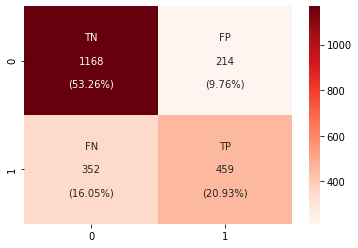

In [150]:
# Predict with Model 2

# Assign and Impute X
X_test_imp = imputer2.transform(X_test1)

# Assign y
y_test = np.ravel(Y_test1)

# Predict
y_pred2 = model2.predict(X_test_imp)
y_pred_proba2 = model2.predict_proba(X_test_imp)

print("XGBoost Model\n")

# print classification report
print("\nClassification Report:\n",)
print(metrics.classification_report(y_test, y_pred2, digits=2))

# print balanced accuracy score
print("Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_test, y_pred2)*100))

# calculate ROC_AUC score
auc = roc_auc_score(y_test, y_pred2)
print('ROC_AUC: %.3f' % auc, "\n\n")

# generate pretty Confusion Matrix
result = confusion_matrix(y_test, y_pred2)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')


In [151]:
# # generate cross validation scores
# score = cross_val_score(model2, X_test_imp, y_test, cv=10, scoring='roc_auc')
# print("%0.2f ROC_AUC with a standard deviation of %0.2f" % (score.mean(), score.std()))

# score = cross_val_score(model2, X_test_imp, y_test, cv=10, scoring='balanced_accuracy')
# print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (score.mean(), score.std()))

# ppv = cross_val_score(model2, X_test_imp, y_test, cv=10, scoring='precision')
# print("%0.2f PPV with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))


## Export Model 1 predictions for test1

In [152]:
# convert prediction probabilities into a dataframe with index corresponding to Y_test df
y_pred_proba_df1 = pd.DataFrame(y_pred_proba1, columns = ['m1_proba_0', 'm1_proba_1'], index = Y_test1.index)

# convert predicted labels into a dataframe with index corresponding to Y_test df
y_pred_df1 = pd.DataFrame(y_pred1, columns = ['m1_pred'], index = Y_test1.index)

# join predicted labels with prediction probabilities
predictions1 = y_pred_df1.join(y_pred_proba_df1)

# left merge predicted values with model_data
analysis_df1 = predictions1.merge(model_data, how='left', left_on=predictions1.index, right_on=model_data.index)

# generate df of site predictions and probabilities
output_df1 = analysis_df1[['da_number', 'cwa_determination', 'm1_pred', 'm1_proba_0', 'm1_proba_1']]

# save to file
output_df1.to_csv(r"/content/drive/MyDrive/Colab/altmodel/xgb_predictions_model1_test1.csv ")

## Export Model 2 predictions for test1

In [153]:
# convert prediction probabilities into a dataframe with index corresponding to Y_test df
y_pred_proba_df2 = pd.DataFrame(y_pred_proba2, columns = ['m2_proba_0', 'm2_proba_1'], index = Y_test1.index)

# convert predicted labels into a dataframe with index corresponding to Y_test df
y_pred_df2 = pd.DataFrame(y_pred2, columns = ['m2_pred'], index = Y_test1.index)

# join predicted labels with prediction probabilities
predictions2 = y_pred_df2.join(y_pred_proba_df2)

# left merge predicted values with model_data
analysis_df2 = predictions2.merge(model_data, how='left', left_on=predictions2.index, right_on=model_data.index)

# generate df of site predictions and probabilities
output_df2 = analysis_df2[['da_number', 'cwa_determination', 'm2_pred', 'm2_proba_0', 'm2_proba_1']]

# save to file
output_df2.to_csv(r"/content/drive/MyDrive/Colab/altmodel/xgb_predictions_model2_test1.csv ")

## Merge predictions for test1

In [154]:
# Merge predictions
combined_models_train_df = pd.merge(output_df1, output_df2, on='da_number', how='outer')

# Drop duplicate column
combined_models_train_df.rename(columns = {'cwa_determination_x':'cwa_determination'}, inplace = True)
combined_models_train_df.drop(['cwa_determination_y'], axis=1, inplace = True)

# STAGE 2: Prepare test data for Logistic Regression using XGB models

## Predict test2 with Model 1

XGBoost Model 1


Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1383
           1       0.65      0.56      0.60       810

    accuracy                           0.73      2193
   macro avg       0.71      0.69      0.70      2193
weighted avg       0.72      0.73      0.72      2193

Balanced Accuracy Score: 69.22%
ROC_AUC: 0.692 




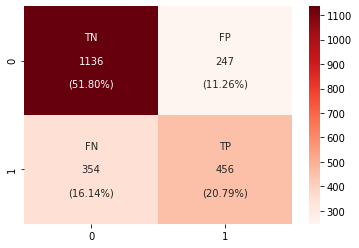

In [155]:
# Predict with Model 1

# Assign and Impute X
X_test_imp = imputer1.transform(X_test2)

# Assign y
y_test = np.ravel(Y_test2)

# Predict 
y_pred1 = model1.predict(X_test_imp)
y_pred_proba1 = model1.predict_proba(X_test_imp)

print("XGBoost Model 1\n")

# print classification report
print("\nClassification Report:\n",)
print(metrics.classification_report(y_test, y_pred1, digits=2))

# print balanced_accuracy score
print("Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_test, y_pred1)*100))

# calculate ROC_AUC score
auc = roc_auc_score(y_test, y_pred1)
print('ROC_AUC: %.3f' % auc, "\n\n")

# generate pretty Confusion Matrix
result = confusion_matrix(y_test, y_pred1)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')

In [156]:
# generate cross validation scores
score = cross_val_score(model1, X_test_imp, y_test, cv=10, scoring='roc_auc')
print("%0.2f ROC_AUC with a standard deviation of %0.2f" % (score.mean(), score.std()))

score = cross_val_score(model1, X_test_imp, y_test, cv=10, scoring='balanced_accuracy')
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (score.mean(), score.std()))

ppv = cross_val_score(model1, X_test_imp, y_test, cv=10, scoring='precision')
print("%0.2f PPV with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

0.77 ROC_AUC with a standard deviation of 0.03
0.68 balanced accuracy with a standard deviation of 0.03
0.62 PPV with a standard deviation of 0.04


## Predict test2 with Model 2

XGBoost Model


Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.83      0.79      1383
           1       0.66      0.57      0.61       810

    accuracy                           0.73      2193
   macro avg       0.71      0.70      0.70      2193
weighted avg       0.73      0.73      0.73      2193

Balanced Accuracy Score: 69.71%
ROC_AUC: 0.697 




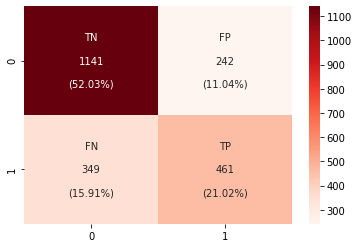

In [157]:
# Predict with Model 2

# Assign and Impute X
X_test_imp = imputer2.transform(X_test2)

# Assign y
y_test = np.ravel(Y_test2)

# Predict
y_pred2 = model2.predict(X_test_imp)
y_pred_proba2 = model2.predict_proba(X_test_imp)

print("XGBoost Model\n")

# print classification report
print("\nClassification Report:\n",)
print(metrics.classification_report(y_test, y_pred2, digits=2))

# print balanced accuracy score
print("Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_test, y_pred2)*100))

# calculate ROC_AUC score
auc = roc_auc_score(y_test, y_pred2)
print('ROC_AUC: %.3f' % auc, "\n\n")

# generate pretty Confusion Matrix
result = confusion_matrix(y_test, y_pred2)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')


In [158]:
# generate cross validation scores
score = cross_val_score(model2, X_test_imp, y_test, cv=10, scoring='roc_auc')
print("%0.2f ROC_AUC with a standard deviation of %0.2f" % (score.mean(), score.std()))

score = cross_val_score(model2, X_test_imp, y_test, cv=10, scoring='balanced_accuracy')
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (score.mean(), score.std()))

ppv = cross_val_score(model2, X_test_imp, y_test, cv=10, scoring='precision')
print("%0.2f PPV with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

0.78 ROC_AUC with a standard deviation of 0.04
0.69 balanced accuracy with a standard deviation of 0.03
0.65 PPV with a standard deviation of 0.04


## Export Model 1 predictions for test2

In [159]:
# convert prediction probabilities into a dataframe with index corresponding to Y_test df
y_pred_proba_df1 = pd.DataFrame(y_pred_proba1, columns = ['m1_proba_0', 'm1_proba_1'], index = Y_test2.index)

# convert predicted labels into a dataframe with index corresponding to Y_test df
y_pred_df1 = pd.DataFrame(y_pred1, columns = ['m1_pred'], index = Y_test2.index)

# join predicted labels with prediction probabilities
predictions1 = y_pred_df1.join(y_pred_proba_df1)

# left merge predicted values with model_data
analysis_df1 = predictions1.merge(model_data, how='left', left_on=predictions1.index, right_on=model_data.index)

# generate df of site predictions and probabilities
output_df1 = analysis_df1[['da_number', 'cwa_determination', 'm1_pred', 'm1_proba_0', 'm1_proba_1']]

# save to file
output_df1.to_csv(r"/content/drive/MyDrive/Colab/altmodel/xgb_predictions_model1_test2.csv ")

## Export Model 2 predictions for test2

In [160]:
# convert prediction probabilities into a dataframe with index corresponding to Y_test df
y_pred_proba_df2 = pd.DataFrame(y_pred_proba2, columns = ['m2_proba_0', 'm2_proba_1'], index = Y_test2.index)

# convert predicted labels into a dataframe with index corresponding to Y_test df
y_pred_df2 = pd.DataFrame(y_pred2, columns = ['m2_pred'], index = Y_test2.index)

# join predicted labels with prediction probabilities
predictions2 = y_pred_df2.join(y_pred_proba_df2)

# left merge predicted values with model_data
analysis_df2 = predictions2.merge(model_data, how='left', left_on=predictions2.index, right_on=model_data.index)

# generate df of site predictions and probabilities
output_df2 = analysis_df2[['da_number', 'cwa_determination', 'm2_pred', 'm2_proba_0', 'm2_proba_1']]

# save to file
output_df2.to_csv(r"/content/drive/MyDrive/Colab/altmodel/xgb_predictions_model2_test2.csv ")

## Merge predictions for test2

In [161]:
# Merge predictions
combined_models_test_df = pd.merge(output_df1, output_df2, on='da_number', how='outer')

# Drop duplicate column
combined_models_test_df.rename(columns = {'cwa_determination_x':'cwa_determination'}, inplace = True)
combined_models_test_df.drop(['cwa_determination_y'], axis=1, inplace = True)

# STAGE 3: Ensemble

## Train Model 3

In [162]:
# updating with max of probabilities
# combined_models_train_df['feature1'] = np.where(combined_models_train_df['m1_proba_1'] > combined_models_train_df['m2_proba_1'], combined_models_train_df['m1_proba_1'], combined_models_train_df['m2_proba_1'] ) 
# combined_models_train_df['feature2'] = np.where(combined_models_train_df['m1_proba_0'] > combined_models_train_df['m2_proba_0'], combined_models_train_df['m1_proba_0'], combined_models_train_df['m2_proba_0'] ) 
# combined_models_test_df['feature1'] = np.where(combined_models_test_df['m1_proba_1'] > combined_models_test_df['m2_proba_1'], combined_models_test_df['m1_proba_1'], combined_models_test_df['m2_proba_1'] ) 
# combined_models_test_df['feature2'] = np.where(combined_models_test_df['m1_proba_0'] > combined_models_test_df['m2_proba_0'], combined_models_test_df['m1_proba_0'], combined_models_test_df['m2_proba_0'] ) 

# updating with max probabilities and predictions (Shobha's method) (99, 97, 87)
# combined_models_train_df['feature1'] = np.where(combined_models_train_df['m1_pred'] == 1, combined_models_train_df['m1_proba_1'], combined_models_train_df['m1_proba_0'] ) 
# combined_models_train_df['feature2'] = np.where(combined_models_train_df['m2_pred'] == 1, combined_models_train_df['m2_proba_1'], combined_models_train_df['m2_proba_0'] ) 
# combined_models_test_df['feature1'] = np.where(combined_models_test_df['m1_pred'] == 1, combined_models_test_df['m1_proba_1'], combined_models_test_df['m2_proba_1'] ) 
# combined_models_test_df['feature2'] = np.where(combined_models_test_df['m2_pred'] == 1, combined_models_test_df['m2_proba_1'], combined_models_test_df['m2_proba_0'] ) 

# updating with max probabilities and sum of predictions (100, 97, 87)
# combined_models_train_df['feature0'] = combined_models_train_df['m1_pred'] + combined_models_train_df['m2_pred'] 
# combined_models_train_df['feature1'] = np.where(combined_models_train_df['m1_pred'] == 1, combined_models_train_df['m1_proba_1'], combined_models_train_df['m1_proba_0'] ) 
# combined_models_train_df['feature2'] = np.where(combined_models_train_df['m2_pred'] == 1, combined_models_train_df['m2_proba_1'], combined_models_train_df['m2_proba_0'] ) 
# combined_models_test_df['feature0'] = combined_models_test_df['m1_pred'] + combined_models_test_df['m2_pred'] 
# combined_models_test_df['feature1'] = np.where(combined_models_test_df['m1_pred'] == 1, combined_models_test_df['m1_proba_1'], combined_models_test_df['m2_proba_1'] ) 
# combined_models_test_df['feature2'] = np.where(combined_models_test_df['m2_pred'] == 1, combined_models_test_df['m2_proba_1'], combined_models_test_df['m2_proba_0'] ) 

# updating with sum of predictions and sum of probabilities (100, 98, 91)
combined_models_train_df['feature0'] = combined_models_train_df['m1_pred'] + combined_models_train_df['m2_pred'] 
combined_models_train_df['feature1'] = combined_models_train_df['m1_proba_0'] + combined_models_train_df['m2_proba_0'] 
combined_models_train_df['feature2'] = combined_models_train_df['m1_proba_1'] + combined_models_train_df['m2_proba_1'] 
combined_models_test_df['feature0'] = combined_models_test_df['m1_pred'] + combined_models_test_df['m2_pred'] 
combined_models_test_df['feature1'] = combined_models_test_df['m1_proba_0'] + combined_models_test_df['m2_proba_0']  
combined_models_test_df['feature2'] = combined_models_test_df['m1_proba_1'] + combined_models_test_df['m2_proba_1']  

In [163]:
# Define X
X_train_lr = combined_models_train_df[['m1_pred', 'm2_pred', 'm1_proba_0', 'm1_proba_1', 'm2_proba_0', 'm2_proba_1']]
# X_train_lr = combined_models_train_df[['m1_pred', 'm2_pred', 'feature1', 'feature2']]
# X_train_lr = combined_models_train_df[['feature0', 'feature1', 'feature2']]
# X_train_lr = combined_models_train_df[['m1_proba_0', 'm1_proba_1', 'm2_proba_0', 'm2_proba_1']]


Y_train_lr = combined_models_train_df[['cwa_determination']]

# Define y
y_train_lr = np.ravel(Y_train_lr)

# Instantiate LR model
model3 = LogisticRegression()

# Train model
model3.fit(X_train_lr, y_train_lr)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Predict with Model 3


Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.85      0.80      1383
           1       0.68      0.56      0.61       810

    accuracy                           0.74      2193
   macro avg       0.72      0.70      0.71      2193
weighted avg       0.73      0.74      0.73      2193

Balanced Accuracy Score: 70.18%
ROC_AUC: 0.702 




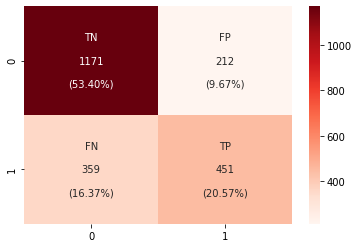

In [164]:
# Define X
X_test_lr = combined_models_test_df[['m1_pred', 'm2_pred', 'm1_proba_0', 'm1_proba_1', 'm2_proba_0', 'm2_proba_1']]
# X_test_lr = combined_models_test_df[['m1_pred', 'm2_pred', 'feature1', 'feature2']]
# X_test_lr = combined_models_test_df[['feature0', 'feature1', 'feature2']]
# X_test_lr = combined_models_test_df[['m1_proba_0', 'm1_proba_1', 'm2_proba_0', 'm2_proba_1']]

# Define y
Y_test_lr = combined_models_test_df[['cwa_determination']]
y_test_lr = np.ravel(Y_test_lr)

# Predict 
y_pred_lr = model3.predict(X_test_lr)

# print classification report
print("\nClassification Report:\n",)
print(metrics.classification_report(y_test_lr, y_pred_lr, digits=2))

# print accuracy score
print("Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_test_lr, y_pred_lr)*100))

# calculate AUC
auc = roc_auc_score(y_test_lr, y_pred_lr)
print('ROC_AUC: %.3f' % auc, "\n\n")

# Generate pretty Confusion Matrix
result = confusion_matrix(y_test_lr, y_pred_lr)
group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')


In [165]:
# generate cross validation scores
score = cross_val_score(model3, X_test_lr, y_test_lr, cv=10, scoring='roc_auc')
print("%0.2f ROC_AUC with a standard deviation of %0.2f" % (score.mean(), score.std()))

score = cross_val_score(model3, X_test_lr, y_test_lr, cv=10, scoring='balanced_accuracy')
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (score.mean(), score.std()))

ppv = cross_val_score(model3, X_test_lr, y_test_lr, cv=10, scoring='precision')
print("%0.2f PPV with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

0.80 ROC_AUC with a standard deviation of 0.03
0.70 balanced accuracy with a standard deviation of 0.04
0.70 PPV with a standard deviation of 0.07


# APPENDIX

In [ ]:
# estimate bias and variance
mse, bias, var = bias_variance_decomp(clf, X_train.to_numpy(), y_train, X_test.to_numpy(), y_test, loss='mse', random_seed=1)

# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

In [ ]:
# generate PPV of positive class
y_test = np.ravel(Y_test)
ppv = cross_val_score(model2, X_test, y_test, cv=10, scoring='precision')
print("%0.2f accuracy with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

In [ ]:
# How to impute Nans at training time

from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_train)

# Impute our data, then train
X_train_imp = imputer.transform(X_train)
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train_imp, Y_train)

for X_test in [X_test_1, X_test_2, X_test_3]:
    # Impute each test item, then predict
    X_test_imp = imputer.transform(X_test)
    print(X_test, '->', clf.predict(X_test_imp))



# Imputing with mean value
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=80)



# # Impute nans 
# for c in X.columns:
#   # X.fillna(value=X[c].mean(), inplace=True)
#   # X.fillna(value=X[c].mode()[0], inplace=True)

In [ ]:
# Using isna() to select all rows with NaN under a single DataFrame column:
df[df['column name'].isna()]

# Using isnull() to select all rows with NaN under a single DataFrame column:
df[df['column name'].isnull()]

# Using isna() to select all rows with NaN under an entire DataFrame:
df[df.isna().any(axis=1)]

# Using isnull() to select all rows with NaN under an entire DataFrame:
df[df.isnull().any(axis=1)]

In [ ]:
# sorting by date
df["date_col"] = pd.to_datetime(df["date_col"])
df = df.sort_values(by="date_col")

In [ ]:
# code for joe
df = X_hold_out
tmp = df.merge(model_data, how='left', left_on=df.index, right_on=model_data.index)
da_list = tmp[['da_number']]
da_list.to_csv(r"/content/drive/MyDrive/Colab/altmodel/hold_out.csv ")

In [ ]:
# hold-out by district
# d = "Chicago"

# # district list
# arr = full_df['district'].unique()
# new_arr = np.delete(arr, np.where(arr == d))

# # Extract model data
# model_data = model_data_tmp[model_data_tmp.district.isin(new_arr)].copy()
# model_data.reset_index(drop=True, inplace=True)

# # Extract hold_out dataset
# hold_out = model_data_tmp[model_data_tmp.district.isin([d])].copy()
# hold_out.reset_index(drop=True, inplace=True)

# # Prepare list of cols to be dropped, for later use
# drop_cols = ['da_number', 'district', 'latitude', 'longitude', 'cwa_determination']

# print(model_data_tmp.shape[0])
# print(model_data.shape[0])
# print(hold_out.shape[0])

In [ ]:
# hold-out by chronological separation

# model_data_tmp['date_issued_or_denied'] = pd.to_datetime(model_data_tmp['date_issued_or_denied'])
# model_data_tmp.sort_values(by='date_issued_or_denied', inplace=True)
# model_data_tmp.reset_index(drop=True, inplace=True)

# total = model_data_tmp.shape[0]
# n1 = total-2000

# # Extract model data
# model_data = model_data_tmp.head(n1)
# model_data.reset_index(drop=True, inplace=True)

# # Extract hold_out dataset
# hold_out = model_data_tmp.tail(2000)
# # hold_out.reset_index(drop=True, inplace=True)

# # Prepare list of cols to be dropped, for later use
# drop_cols = ['date_issued_or_denied', 'da_number', 'district', 'latitude', 'longitude', 'cwa_determination']

# print(model_data_tmp.shape[0])
# print(model_data.shape[0])
# print(hold_out.shape[0])


In [ ]:
# model1 = RandomForestClassifier(n_estimators=1500,random_state=42, max_depth= 80, class_weight={0:1,1:1},
#                              min_samples_leaf=1,oob_score='True')

# model2 = RandomForestClassifier(n_estimators=1500,random_state=42, max_depth= 80, class_weight={0:1,1:1},
#                              min_samples_leaf=1,oob_score='True')

## Model Parameters

In [ ]:
# ROUND4 : tuned using "train2" and stratify
# # parameters for max balanced_accuracy

# model = XGBClassifier(objective='binary:logistic',
#                        booster='gbtree',
#                        learning_rate=0.2,
#                        n_estimators=1000,
#                        max_depth=8,
#                        min_child_weight=2,
#                        gamma=0.4,
#                        subsample=0.9,
#                        colsample_bytree=0.9,
#                        reg_lambda=0,
#                        reg_alpha=0,
#                        max_delta_step=1,
#                        seed=27,
#                        eval_metric='error'
#                        ) 

In [ ]:
# ROUND3 : tuned using "train1" and stratify
# # parameters for max balanced_accuracy

# model = XGBClassifier(objective='binary:logistic',
#                        booster='gbtree',
#                        learning_rate=0.2,
#                        n_estimators=1000,
#                        max_depth=6,
#                        min_child_weight=2,
#                        gamma=0.3,
#                        subsample=0.9,
#                        colsample_bytree=0.7,
#                        reg_lambda=0,
#                        reg_alpha=0,
#                        max_delta_step=1,
#                        seed=27,
#                        eval_metric='error'
#                        ) 

In [ ]:
# ROUND2 : tuned using "train2" and stratify
# # parameters for max precision

# model = XGBClassifier(objective='binary:logistic',
#                        booster='gbtree',
#                        learning_rate=0.05,
#                        n_estimators=1000,
#                        max_depth=5,
#                        min_child_weight=1,
#                        gamma=0,
#                        subsample=0.9,
#                        colsample_bytree=0.9,
#                        reg_lambda=0,
#                        reg_alpha=50,
#                        max_delta_step=1,
#                        seed=27,
#                        eval_metric='error'
#                        ) 



In [ ]:
# ROUND1 : tuned using "train1" and stratify
# # parameters for max precision

# model = XGBClassifier(objective='binary:logistic',
#                        booster='gbtree',
#                        learning_rate=0.2,
#                        n_estimators=1000,
#                        max_depth=6,
#                        min_child_weight=2,
#                        gamma=0.3,
#                        subsample=1,
#                        colsample_bytree=0.7,
#                        reg_lambda=0,
#                        reg_alpha=50,
#                        max_delta_step=1,
#                        seed=27,
#                        eval_metric='error'
#                        ) 


## Export train1, train2, test1, test2 sets

In [ ]:
result = Y_test1.merge(model_data, how='left', left_on=Y_test1.index, right_on=model_data.index )
test1_list = result.da_number
test1_list.to_csv(r"/content/drive/MyDrive/Colab/altmodel/test1.csv ")


# Train on all data and predict on test 2

XGBoost Model 1


Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1383
           1       0.68      0.60      0.64       810

    accuracy                           0.75      2193
   macro avg       0.73      0.72      0.72      2193
weighted avg       0.74      0.75      0.74      2193

Balanced Accuracy Score: 71.66%
ROC_AUC: 0.717 




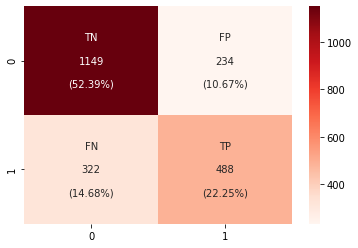

In [ ]:
# Impute 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_train_set)
X_train_imp = imputer1.transform(X_train_set)

# Assign y
y_train = np.ravel(Y_train_set)

# Instantiate model
model = XGBClassifier(objective='binary:logistic',
                       booster='gbtree',
                       learning_rate=0.2,
                       n_estimators=1000,
                       max_depth=6,
                       min_child_weight=2,
                       gamma=0.3,
                       subsample=0.9,
                       colsample_bytree=0.7,
                       reg_lambda=0,
                       reg_alpha=0,
                       max_delta_step=1,
                       seed=27,
                       eval_metric='error'
                       ) 

# Train model
model.fit(X_train_imp, y_train)

# Assign and Impute X
X_test_imp = imputer.transform(X_test2)

# Assign y
y_test = np.ravel(Y_test2)

# Predict 
y_pred = model.predict(X_test_imp)
y_pred_proba = model.predict_proba(X_test_imp)

print("XGBoost Model 1\n")

# print classification report
print("\nClassification Report:\n",)
print(metrics.classification_report(y_test, y_pred, digits=2))

# print balanced_accuracy score
print("Balanced Accuracy Score: %.2f%%" % (metrics.balanced_accuracy_score(y_test, y_pred)*100))

# calculate ROC_AUC score
auc = roc_auc_score(y_test, y_pred)
print('ROC_AUC: %.3f' % auc, "\n\n")

# generate pretty Confusion Matrix
result = confusion_matrix(y_test, y_pred)

group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]

labels = [f"{v1}\n\n{v2}\n\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
              
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(result, annot=labels, fmt="", cmap='Reds')

In [ ]:
# generate cross validation scores
score = cross_val_score(model, X_test_imp, y_test, cv=10, scoring='roc_auc')
print("%0.2f ROC_AUC with a standard deviation of %0.2f" % (score.mean(), score.std()))

score = cross_val_score(model, X_test_imp, y_test, cv=10, scoring='balanced_accuracy')
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (score.mean(), score.std()))

ppv = cross_val_score(model, X_test_imp, y_test, cv=10, scoring='precision')
print("%0.2f PPV with a standard deviation of %0.2f" % (ppv.mean(), ppv.std()))

0.79 ROC_AUC with a standard deviation of 0.04
0.69 balanced accuracy with a standard deviation of 0.05
0.66 PPV with a standard deviation of 0.07


# AD HOC

In [ ]:
for c in full_df.columns:
  print(c)

Unnamed: 0
cwa4
cwa8
cwa7
cwa_determination
cwa5
longitude
cwa3
date_issued_or_denied
latitude
Index
cwa1
da_number
jurisdiction_type
rha_determination
cwa9
cwa2
rha2
potential_wetland
district
cwa6
rha1
hydclprs
mukey
drclassdcd
wtdepaprju
slopegradd
aws025wta
flodfreqdc
wtdepannmi
pondfreqpr
slope_stdev_200m
transition_8_200m
seasonality_mean_200m
transition_0_200m
recurrence_min_200m
elevation_min_200m
seasonality_min_200m
transition_2_200m
slope_min_200m
transition_3_200m
seasonality_stdev_200m
slope_mean_200m
recurrence_mean_200m
transition_5_200m
transition_7_200m
elevation_mean_200m
slope_max_200m
elevation_max_200m
seasonality_max_200m
transition_6_200m
transition_4_200m
elevation_stdev_200m
transition_1_200m
recurrence_max_200m
recurrence_stdev_200m
transition_9_200m
fl_totdasqkm_sum_200m
fl_gnis_name_ind_mean_200m
fl_ftype_streamriver_200m
fl_ftype_connector_200m
fl_intephem_count_200m
fl_startflag_mean_200m
fl_divergence_sum_200m
fl_ftype_coastline_200m
fl_startflag_sum_200m